In [1]:
import pandas as pd  # pip
import numpy as np  # pip
import matplotlib.pyplot as plt  # pip 
from tqdm.notebook import tqdm  # pip; progress bar

from sklearn.feature_extraction.text import TfidfVectorizer  # convert the collection of raw documents to a matrix of TF-IDF features
from sklearn.model_selection import train_test_split  # split the data into random train and test subsets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support  # different kinds of classification indicators
    
from sklearn.naive_bayes import MultinomialNB  # Bayes Model

In [2]:
# define the model with transmitted file information
def load_and_evaluate_model(file_path, sheet_name, column_name, label_column, evaluate_all_metrics=True):
    # catch the specific data content according to transmitted file location AND sheet name
    data = pd.read_excel(file_path, sheet_name)  
    reviews, labels = data[column_name].tolist(), data[label_column].tolist()  # list format for training
    
    X_train, X_test, y_train, y_test = train_test_split(
        # learn the vocabulary and return the document-term matrix (BUT here without parameter api such as "stop_words=")
        # the further exploration would be conducted later for different preprocessed app reviews data
        TfidfVectorizer().fit_transform(reviews), labels, test_size = 0.2, random_state = 68  # 80% data for training, 20% data for testing
    )
    
    model = MultinomialNB()  # set the Bayes model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict this model

    results = {}
    # conserve these performance resutls one by one
    results["accuracy"] = accuracy_score(y_test, y_pred)
    if evaluate_all_metrics:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average = None, labels = ["positive", "neutral", "negative"])  # the performance of each emotion label
        results["precision"] = precision
        results["recall"] = recall
        results["f1-score"] = f1

    return results 


def plot_metrics(metrics_results, metric_name):
    plt.figure(figsize=(14, 8))
    categories = ["positive", "neutral", "negative"]
    
    # list(metrics_results.keys())[0] -> "precision"
    # metrics_results["precision"] -> many methods: content, some_stop_words, stem, lemm......
    methods = list(metrics_results[list(metrics_results.keys())[0]].keys())  
    
    for category_index, category in enumerate(categories):
        category_values = []  # prepare to save results
        for method in methods:
            # [metric_name] would be passed, during using this function
            category_values.append(metrics_results[metric_name][method][category_index])

        # the intuitive color setting
        color = ""
        if category == "positive":
            color = "green"  
        elif category == "neutral":
            color = "blue"  
        elif category == "negative":
            color = "red"   
        
        plt.plot(methods, category_values, marker = "o", linestyle = "-", label = category, color = color)
        
        for i, value in enumerate(category_values):
            plt.text(i, value, f"{value:.2f}", ha = "center", va = "bottom", fontsize = 10)
    
    plt.title(f"Model {metric_name.capitalize()} for Different Text PreProcessing Methods")
    plt.xlabel("Different Text PreProcessing Methods")
    plt.ylabel(metric_name.capitalize())
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()  # the legend for each emotion
    plt.grid(True)
    plt.show()

Evaluating model in different text preprocessed methods:   0%|          | 0/7 [00:00<?, ?it/s]

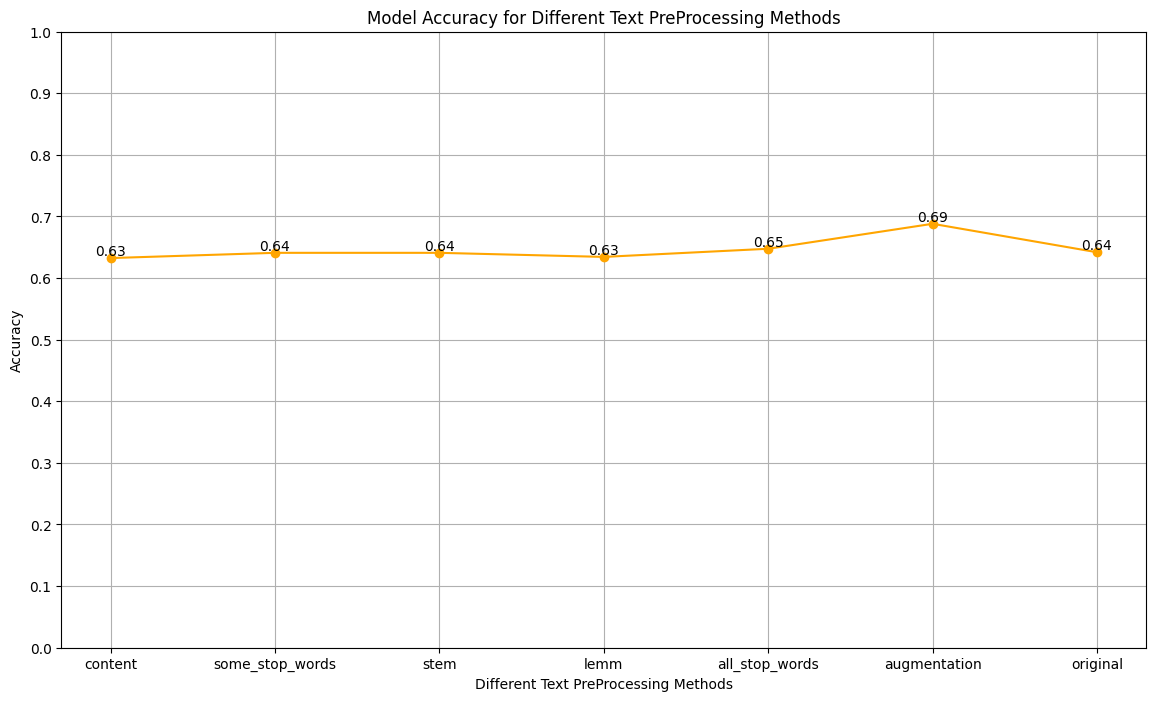

In [3]:
all_results = {
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1-score": {}
}

processed_columns = ["content", "some_stop_words", "stem", "lemm", "all_stop_words"]
additional_methods = ["augmentation", "original"]
label_column = "emotion_label"

file_paths = {
    "processed": "./data/processed_data_after_manual.xlsx",
    "augmentation": "./data/processed_data_after_manual.xlsx",
    "original": "./data/filtered_data_without_manual_check.xlsx"}
sheet_names = {
    "processed": "processed",
    "augmentation": "augmentation",
    "original": "processed"}

# a large FOR loop for ["content", "some_stop_words", "stem", "lemm", "all_stop_words", "augmentation", "original"]
for column in tqdm(processed_columns + additional_methods, desc="Evaluating model in different text preprocessed methods"):

    # NOTE: the file_path was not just "processed", it was the dictionary data structure, "processed" was the key of the dictionary
    file_path = file_paths["processed" if column in processed_columns else column]  # catch the file_path according to the "column" in the FOR loop
    sheet_name = sheet_names["processed" if column in processed_columns else column]  # catch the sheet_name according to the "column" in the FOR loop
    
    results = load_and_evaluate_model(file_path, sheet_name, column if column in processed_columns else processed_columns[0], label_column)  # processed_columns[0] was "content"

    # conserve these performance resutls one by one
    all_results["accuracy"][column] = results["accuracy"]
    all_results["precision"][column] = results["precision"]
    all_results["recall"][column] = results["recall"]
    all_results["f1-score"][column] = results["f1-score"]


# draw the chart for model accuracy
plt.figure(figsize = (14, 8))
plt.plot(list(all_results["accuracy"].keys()), list(all_results["accuracy"].values()), marker = "o", linestyle = "-", color = "orange")

for i, (column, accuracy) in enumerate(all_results["accuracy"].items()):
    plt.text(i, accuracy, f"{accuracy:.2f}", ha = "center", va = "bottom")
    
plt.title("Model Accuracy for Different Text PreProcessing Methods")
plt.xlabel("Different Text PreProcessing Methods")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

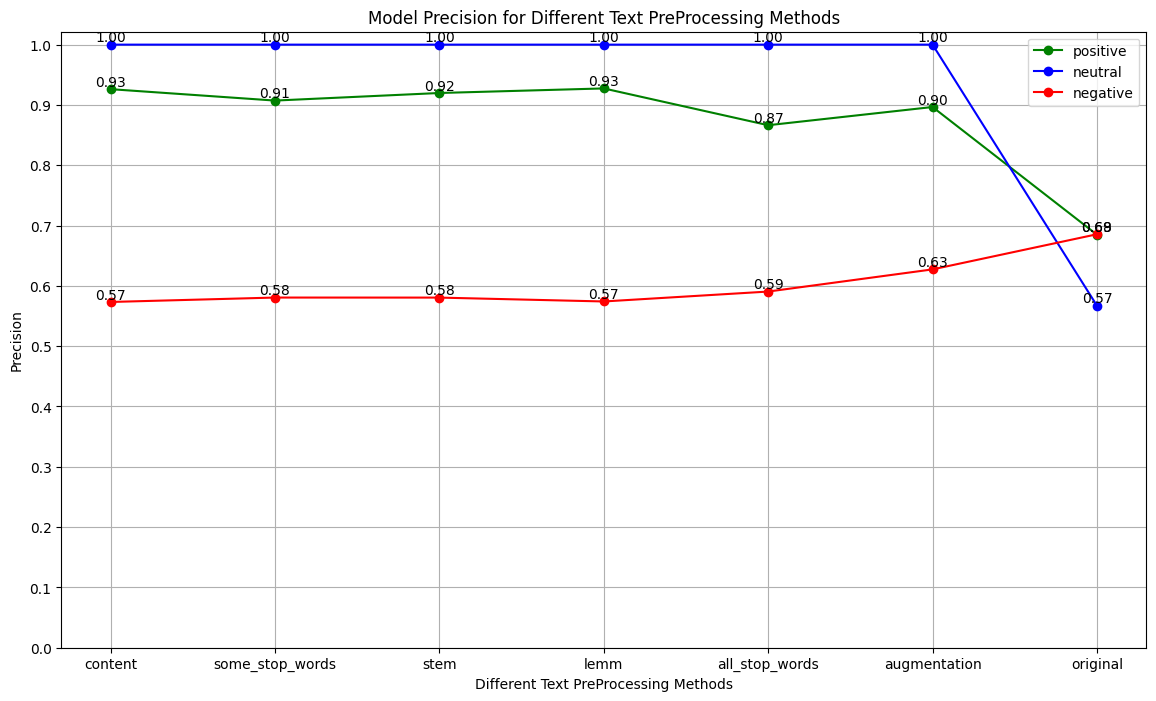

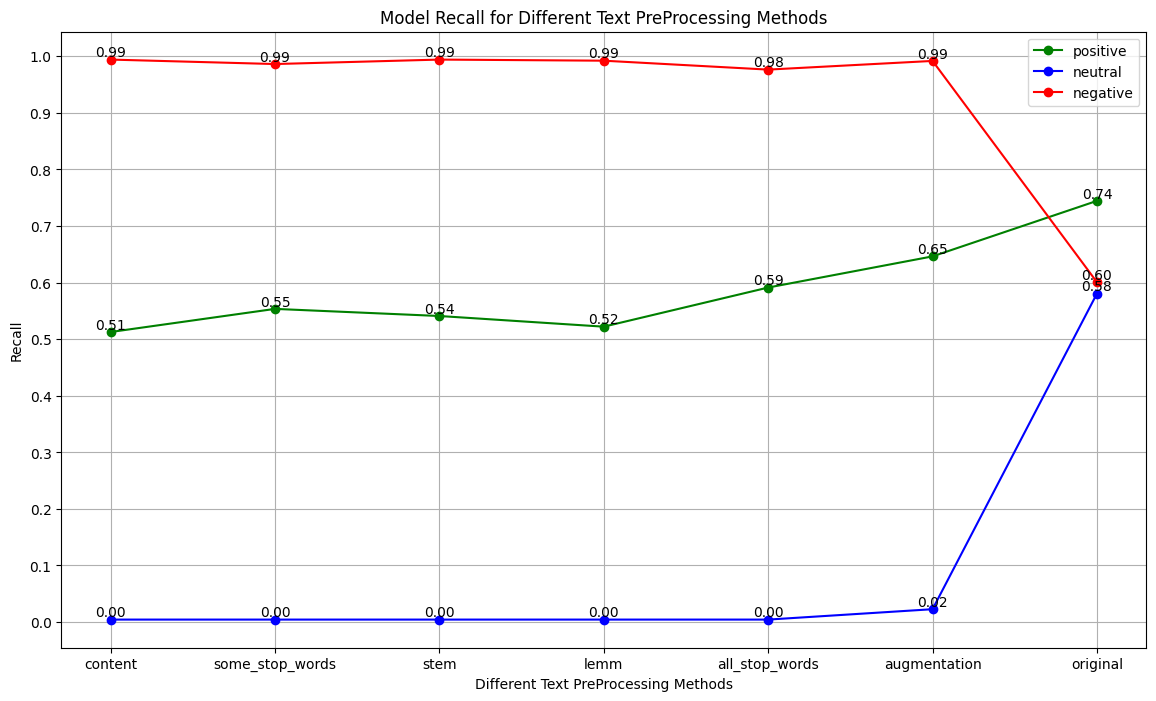

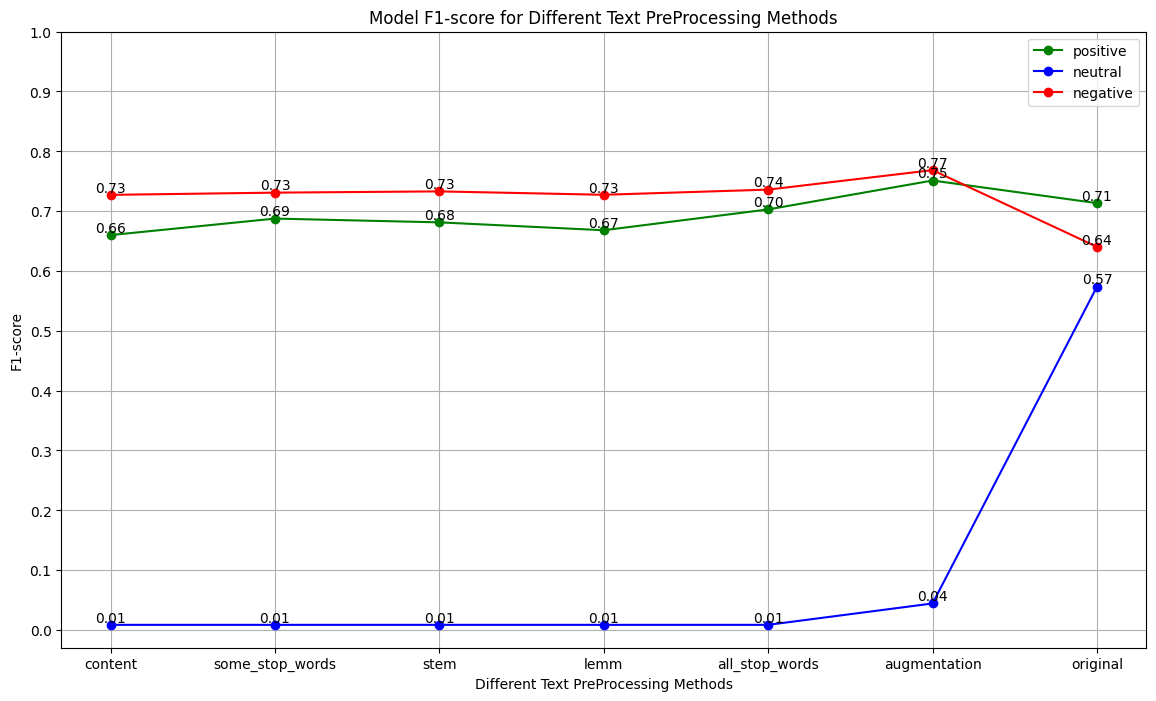

In [4]:
# draw charts for the precision, recall, and F1 score respectively
plot_metrics(all_results, "precision")
plot_metrics(all_results, "recall")
plot_metrics(all_results, "f1-score")

In [5]:
import pandas as pd  # pip
import numpy as np  # pip
import matplotlib.pyplot as plt  # pip 
from tqdm.notebook import tqdm  # pip; progress bar

from sklearn.feature_extraction.text import TfidfVectorizer  # convert the collection of raw documents to a matrix of TF-IDF features
from sklearn.model_selection import train_test_split  # split the data into random train and test subsets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support  # different kinds of classification indicators

from sklearn.naive_bayes import MultinomialNB  # Bayes Model

from sklearn.model_selection import GridSearchCV  # Exhaustive Search for each hyper-parameter setting

import time

In [6]:
data = pd.read_excel("./data/processed_data_after_manual.xlsx", "processed")  # read the data
reviews, labels = data["content"].tolist(), data["emotion_label"].tolist()  # standardizing the format of data and labels

X_train, X_test, y_train, y_test = train_test_split(
        TfidfVectorizer().fit_transform(reviews), labels, test_size = 0.2, random_state = 68
)  # split data into train-test sets, then create the TF-IDF feature matrix for these data
muNB = MultinomialNB()  # set the Bayes model instance

param_grid = {
    "alpha": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    # "alpha": [0.01, 1.0]
}  # different hyper-parameters


start_search_time = time.time()  # start time

# 10-folder cross validation for the Grid Search
# use accuracy as the metric to evaluate model performance to avoid bias and 
# ensure a certain level of generalizability
# n_jobs = -1 meant using all cores in this device CPU
grid_search = GridSearchCV(muNB, param_grid, cv = 10, verbose = 1, scoring = "accuracy", n_jobs = -1)

grid_search.fit(X_train, y_train)  # only use training data to find appropriate parameters
end_search_time = time.time()  # end time
print(f"Executing the time for: {end_search_time - start_search_time} seconds")  # 14-inch M1 pro, 8 cores

# print information of the best hyper-parameters
print("Best parameters:", grid_search.best_params_)
best_alpha = grid_search.best_params_["alpha"]

print("best_alpha: ", best_alpha)

# test the hyper-parameter setting 
knn_best = muNB = MultinomialNB(**grid_search.best_params_)
knn_best.fit(X_train, y_train)
test_score = knn_best.score(X_test, y_test)

print(f"Model Accuracy with the specific setting on the test set: {test_score}")  # the performance overview

Fitting 10 folds for each of 19 candidates, totalling 190 fits
Executing the time for: 0.8365340232849121 seconds
Best parameters: {'alpha': 0.06}
best_alpha:  0.06
Model Accuracy with the specific setting on the test set: 0.6862003780718336


In [7]:
# define the model with transmitted file information and the satisfying hupyer-parameter
def load_and_evaluate_model(file_path, sheet_name, column_name, label_column, best_alpha, evaluate_all_metrics=True):
    # catch the specific data content according to transmitted file location AND sheet name
    data = pd.read_excel(file_path, sheet_name)  
    reviews, labels = data[column_name].tolist(), data[label_column].tolist()  # list format for training
    
    X_train, X_test, y_train, y_test = train_test_split(
        # learn the vocabulary and return the document-term matrix (BUT here without parameter api such as "stop_words=")
        # the further exploration would be conducted later for different preprocessed reviews data
        TfidfVectorizer().fit_transform(reviews), labels, test_size = 0.2, random_state = 68  # 80% data for training, 20% data for testing
    )
    
    model = MultinomialNB(alpha = best_alpha)  # set the Bayes model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict this model

    results = {}
    # conserve these performance resutls one by one
    results["accuracy"] = accuracy_score(y_test, y_pred)
    if evaluate_all_metrics:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average = None, labels = ["positive", "neutral", "negative"])  # the performance of each emotion label
        results["precision"] = precision
        results["recall"] = recall
        results["f1-score"] = f1

    return results 


def plot_metrics(metrics_results, metric_name):
    plt.figure(figsize=(14, 8))
    categories = ["positive", "neutral", "negative"]
    
    # list(metrics_results.keys())[0] -> "precision"
    # metrics_results["precision"] -> many methods: content, some_stop_words, stem, lemm......
    methods = list(metrics_results[list(metrics_results.keys())[0]].keys())  
    
    for category_index, category in enumerate(categories):
        category_values = []  # prepare to save results
        for method in methods:
            # [metric_name] would be passed, during using this function
            category_values.append(metrics_results[metric_name][method][category_index])

        # the intuitive color setting
        color = ""
        if category == "positive":
            color = "green"  
        elif category == "neutral":
            color = "blue"  
        elif category == "negative":
            color = "red"   
        
        plt.plot(methods, category_values, marker = "o", linestyle = "-", label = category, color = color)
        
        for i, value in enumerate(category_values):
            plt.text(i, value, f"{value:.2f}", ha = "center", va = "bottom", fontsize = 10)
    
    plt.title(f"Model {metric_name.capitalize()} for Different Text PreProcessing Methods")
    plt.xlabel("Different Text PreProcessing Methods")
    plt.ylabel(metric_name.capitalize())
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()  # the legend for each emotion
    plt.grid(True)
    plt.show()

    print(f"\n{metric_name.capitalize()} Values for Different Text PreProcessing Methods:\n")
    for category_index, category in enumerate(categories):
        print(f"Emotion label: {category.capitalize()}")
        for method in methods:
            value = metrics_results[metric_name][method][category_index]
            print(f"  Method: {method}, Value: {value:.2f}")
        print("") 

Evaluating model in different text preprocessed methods:   0%|          | 0/7 [00:00<?, ?it/s]

Executing the time for: 3.300394296646118 seconds


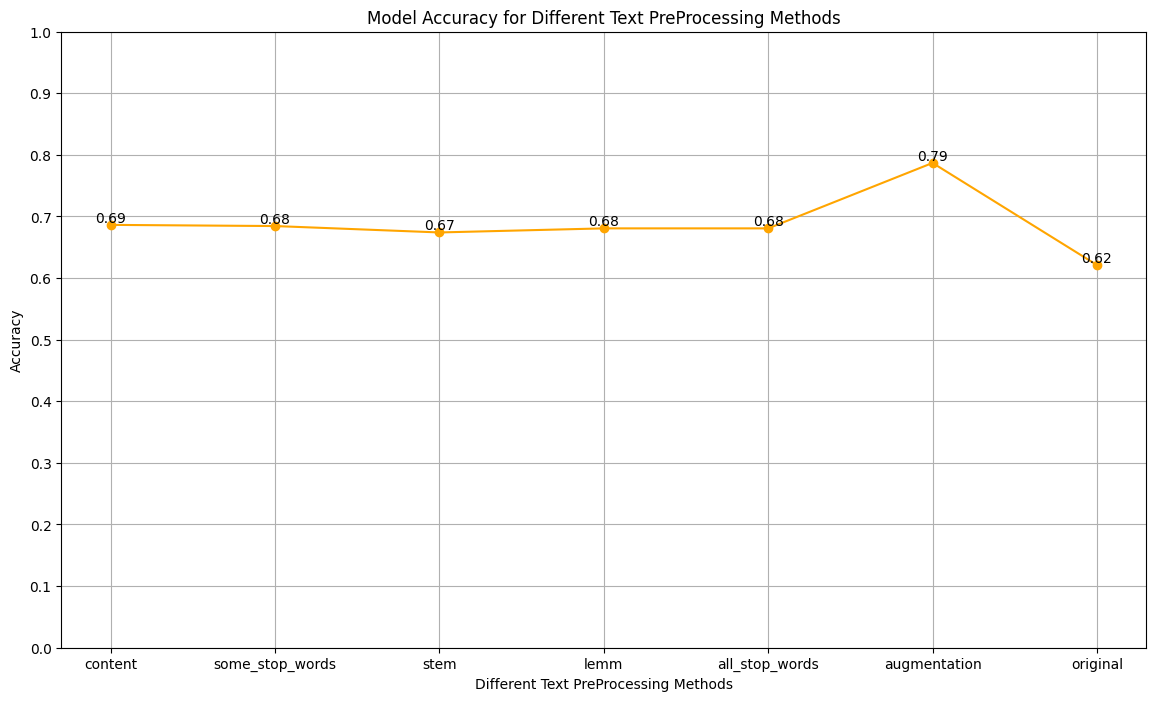

In [8]:
all_results = {
    "accuracy": {},
    "precision": {},
    "recall": {},
    "f1-score": {}
}

processed_columns = ["content", "some_stop_words", "stem", "lemm", "all_stop_words"]
additional_methods = ["augmentation", "original"]
label_column = "emotion_label"

file_paths = {
    "processed": "./data/processed_data_after_manual.xlsx",
    "augmentation": "./data/processed_data_after_manual.xlsx",
    "original": "./data/filtered_data_without_manual_check.xlsx"}
sheet_names = {
    "processed": "processed",
    "augmentation": "augmentation",
    "original": "processed"}

# Progress bar's timer displayed abnormality after downloading files, 
# thus manual time logging was implemented here.
start_time = time.time()  # start time
# a large FOR loop for ["content", "some_stop_words", "stem", "lemm", "all_stop_words", "augmentation", "original"]
for column in tqdm(processed_columns + additional_methods, desc="Evaluating model in different text preprocessed methods"):

    # NOTE: the file_path was not just "processed", it was the dictionary data structure, "processed" was the key of the dictionary
    file_path = file_paths["processed" if column in processed_columns else column]  # catch the file_path according to the "column" in the FOR loop
    sheet_name = sheet_names["processed" if column in processed_columns else column]  # catch the sheet_name according to the "column" in the FOR loop

    # the hyper-parameter setting had already been selected during the Grid Search
    results = load_and_evaluate_model(file_path, sheet_name, column if column in processed_columns else processed_columns[0], label_column, best_alpha)  # processed_columns[0] was "content"

    # conserve these performance resutls one by one
    all_results["accuracy"][column] = results["accuracy"]
    all_results["precision"][column] = results["precision"]
    all_results["recall"][column] = results["recall"]
    all_results["f1-score"][column] = results["f1-score"]
end_time = time.time()  # end time
print(f"Executing the time for: {end_time - start_time} seconds")  # 14-inch M1 pro, 8 cores

# draw the chart for model accuracy
plt.figure(figsize = (14, 8))
plt.plot(list(all_results["accuracy"].keys()), list(all_results["accuracy"].values()), marker = "o", linestyle = "-", color = "orange")

for i, (column, accuracy) in enumerate(all_results["accuracy"].items()):
    plt.text(i, accuracy, f"{accuracy:.2f}", ha = "center", va = "bottom")
    
plt.title("Model Accuracy for Different Text PreProcessing Methods")
plt.xlabel("Different Text PreProcessing Methods")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()

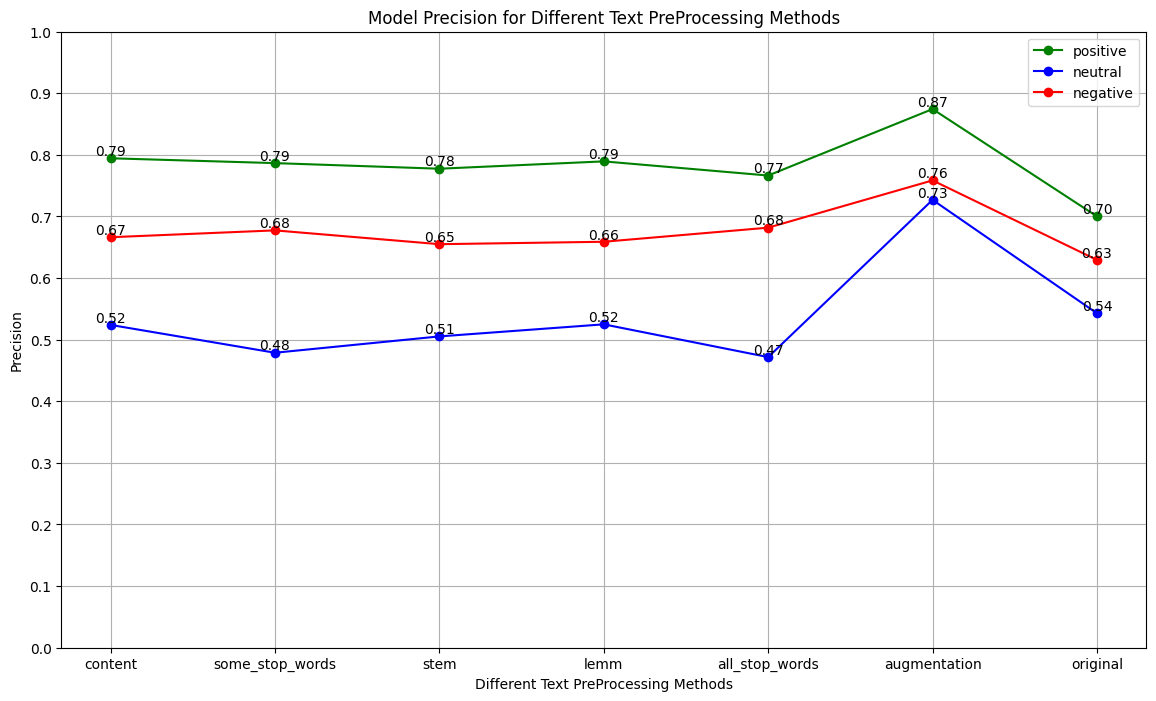


Precision Values for Different Text PreProcessing Methods:

Emotion label: Positive
  Method: content, Value: 0.79
  Method: some_stop_words, Value: 0.79
  Method: stem, Value: 0.78
  Method: lemm, Value: 0.79
  Method: all_stop_words, Value: 0.77
  Method: augmentation, Value: 0.87
  Method: original, Value: 0.70

Emotion label: Neutral
  Method: content, Value: 0.52
  Method: some_stop_words, Value: 0.48
  Method: stem, Value: 0.51
  Method: lemm, Value: 0.52
  Method: all_stop_words, Value: 0.47
  Method: augmentation, Value: 0.73
  Method: original, Value: 0.54

Emotion label: Negative
  Method: content, Value: 0.67
  Method: some_stop_words, Value: 0.68
  Method: stem, Value: 0.65
  Method: lemm, Value: 0.66
  Method: all_stop_words, Value: 0.68
  Method: augmentation, Value: 0.76
  Method: original, Value: 0.63


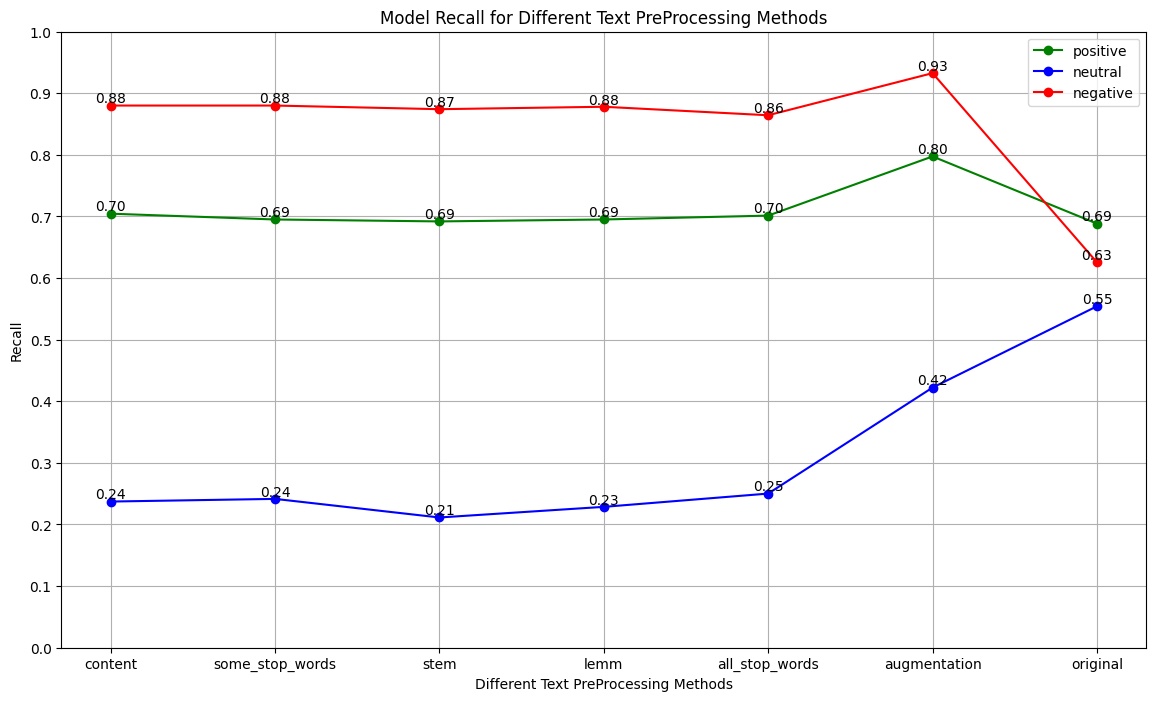


Recall Values for Different Text PreProcessing Methods:

Emotion label: Positive
  Method: content, Value: 0.70
  Method: some_stop_words, Value: 0.69
  Method: stem, Value: 0.69
  Method: lemm, Value: 0.69
  Method: all_stop_words, Value: 0.70
  Method: augmentation, Value: 0.80
  Method: original, Value: 0.69

Emotion label: Neutral
  Method: content, Value: 0.24
  Method: some_stop_words, Value: 0.24
  Method: stem, Value: 0.21
  Method: lemm, Value: 0.23
  Method: all_stop_words, Value: 0.25
  Method: augmentation, Value: 0.42
  Method: original, Value: 0.55

Emotion label: Negative
  Method: content, Value: 0.88
  Method: some_stop_words, Value: 0.88
  Method: stem, Value: 0.87
  Method: lemm, Value: 0.88
  Method: all_stop_words, Value: 0.86
  Method: augmentation, Value: 0.93
  Method: original, Value: 0.63


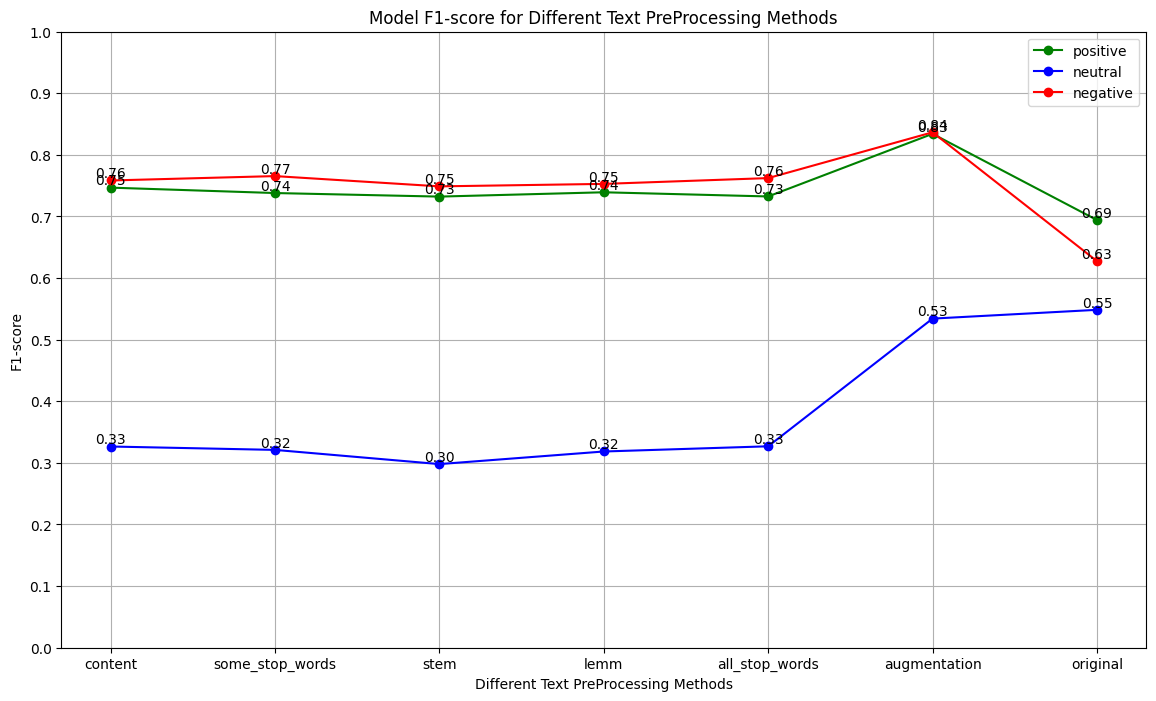


F1-score Values for Different Text PreProcessing Methods:

Emotion label: Positive
  Method: content, Value: 0.75
  Method: some_stop_words, Value: 0.74
  Method: stem, Value: 0.73
  Method: lemm, Value: 0.74
  Method: all_stop_words, Value: 0.73
  Method: augmentation, Value: 0.83
  Method: original, Value: 0.69

Emotion label: Neutral
  Method: content, Value: 0.33
  Method: some_stop_words, Value: 0.32
  Method: stem, Value: 0.30
  Method: lemm, Value: 0.32
  Method: all_stop_words, Value: 0.33
  Method: augmentation, Value: 0.53
  Method: original, Value: 0.55

Emotion label: Negative
  Method: content, Value: 0.76
  Method: some_stop_words, Value: 0.77
  Method: stem, Value: 0.75
  Method: lemm, Value: 0.75
  Method: all_stop_words, Value: 0.76
  Method: augmentation, Value: 0.84
  Method: original, Value: 0.63


In [9]:
# draw charts for the precision, recall, and F1 score respectively
plot_metrics(all_results, "precision")
plot_metrics(all_results, "recall")
plot_metrics(all_results, "f1-score")